In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage as ndi
from scipy.ndimage import distance_transform_edt
import cv2
from PIL import Image
import os
import random

from skimage import data
from skimage.color import rgb2hsv, rgb2gray
from utils import load_input_image
from segmentation import Segmentation
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import normalize


In [395]:
sorted_pieces = [
    [[0,2,8,9,10,12,13,14,19], [1,5,6,11,16,21,22,25,26], [3,4,7,15,17,18,20,24,27] ,[23]],
    [[2,7,4,8,10,11,12,12,14], [0,1,5,6,9,15,16,17,19]  , []                        ,[3,18,20]],
    [[2,5,6,17,19,20,22,23,24],[1,4,9,13,15,18,21,25,26], [3,7,8,10,11,12,14,16,27] ,[]],
    [[0,1,2,5,11,12,13,16,17], [3,4,6,7,8,9,15,18,20]   , []                        ,[10,14,19]],
    [[1,3,5,7,8,9,11,15,18]  , [2,4,6,10,12,13,14,17,19], []                        ,[0,16]],
    [[3,4,6,7,9,10,15,19,24],  [0,8,12,14,16,17,18,20,26],[1,2,5,11,13,21,22,23,27] ,[25]],
    [[0,2,5,8,10,18,25,26,27], [1,3,4,12,14,15,17,21,23], [6,7,9,11,16,19,22,24,28] ,[13, 20]],
    [[0,1,7,9,12,14,19,23,27], [2,4,5,13,18,22,24,25,26], [3,8,10,11,15,16,17,20,21],[6]],
    [[0,1,2,5,6,8,11,12,14,15,16,17,19,20,22,25],[3,4,7,9,10,13,18,21,24],[]        ,[23]],
    [[0,2,4,5,6,13,17,23,25],  [1,9,10,12,14,15,16,19,22],[7,8,18,20,21,24,26,27,28],[3,11]],
    [[0,1,8,12,14,17,18,20,22],[2,3,4,9,10,15,16,21,23] , [5,6,7,11,13,19,25,26,27] ,[24]],
    [[1,2,5,6,9,11,14,15,18],  [3,4,7,8,10,12,13,16,17],  []                        ,[0]]
]

In [353]:

def create_nearest_white_pixel_map(image):
    inverted_image = np.logical_not(image)
    distance_map = distance_transform_edt(inverted_image)
    nearest_white_pixel_map = distance_map.astype("int")

    return nearest_white_pixel_map

def minmap(map, bin_img):
    d = np.sum(map[bin_img])
    d = min(d, np.sum(map[np.flipud(bin_img)]))
    d = min(d, np.sum(map[np.fliplr(bin_img)]))
    d = min(d, np.sum(map[bin_img.T]))
    return d

def get_distances(pieces, threshold=4):

    bin_imgs = []
    distance_maps   = []
    distance_maps_2 = []

    distances = []

    for img in pieces:
        transform = np.fft.fft2(rgb2gray(img))
        fshift = np.fft.fftshift(transform)
        bin_img = np.log(np.abs(fshift[50:-50, 50:-50]))> threshold
        bin_imgs.append(bin_img)
        distance_maps.append(create_nearest_white_pixel_map(bin_img))

    for map in distance_maps:
        
        arr = np.array([minmap(map, b) for b in bin_imgs])
        distances.append(arr)
    
    distances = np.array(distances)
    normalized_distances = normalize(distances, axis=0)

    return normalized_distances

In [434]:
def get_features(img):
    # COLOR
    img_hsv = rgb2hsv(img)
    means = np.median(img, axis=(0, 1))
    std = np.std(img, axis=(0, 1))
    means_hsv = np.median(img_hsv, axis=(0, 1))
    std_hsv = np.std(img_hsv, axis=(0, 1))

    # FOURIER
    transform = np.fft.fft2(rgb2gray(img))
    fshift = np.fft.fftshift(transform)
    

    ft_mean = np.mean(np.log(np.abs(fshift[50:-50, 50:-50])))
    ft_std = np.std(np.log(np.abs(fshift[50:-50, 50:-50])))

    logfshfit = np.log(np.abs(fshift[50:-50, 50:-50])) > 5.5
    pos = (np.where(logfshfit))
    v = np.zeros((pos[0].shape[0], 2))
    v[:,0] = pos[0]
    v[:,1] = pos[1]
    
    eigval = np.array([1,1])
    eigvec = np.array([[1, 0], [0, 1]])
    n_nonzero = 0

    if np.sum(logfshfit) > 1:

        cov = np.cov(v.T)
        
        eigval, eigvec = np.linalg.eig(cov)

        n_nonzero = np.count_nonzero(logfshfit)


    v = eigvec[0]
    if np.abs(eigval[1]) > np.abs(eigval[0]):
        v = eigvec[1]

    angle = np.arctan2(v[1], v[0]) % (np.pi / 2)

    # GABOR
    gamma = 0.5
    phi = np.pi / 2
    ksizes = [20, 40, 60]
    nth = 24
    thetas = np.linspace(0, 2*np.pi, nth)
    freqs = [1, 3]

    means_gabor = []
    std_gabor = []
    thetas_max = []
    for ksize in ksizes:
        sigma = 2 * ksize / 10
        for f in freqs:
            lamda = ksize / f
            mean_max = np.zeros((1,3))
            std_max = np.zeros((1,3))
            theta_max = 0
            for theta in thetas:
                kernel = cv2.getGaborKernel(
                    (ksize, 2*ksize), sigma, theta, lamda, gamma, phi
                )
                f_img = cv2.filter2D(rgb2hsv(img), cv2.CV_8UC3, kernel)
                means_f = np.mean(np.abs(f_img), axis=(0, 1))
                if np.sum(means_f) > np.sum(mean_max):
                    std_max = np.std(np.abs(f_img), axis=(0, 1))
                    theta_max = theta
                    mean_max = means_f
            means_gabor.extend(list(mean_max))
            std_gabor.extend(list(std_max))
            thetas_max.append(theta_max % (np.pi / 2))

    
    return np.hstack(
        [
            means,
            std,
            means_hsv,
            std_hsv,
            means_gabor,
            std_gabor,
            thetas_max,
            # ft_mean,
            # ft_std,
            eigval.ravel(),
            angle,
            n_nonzero
        ]
    )

In [2]:
def load_textures(folder="train2_solutions", path="data_project"):
    paths = os.path.join(path, folder)
    files = os.listdir(paths)
    list_textures = []
    for file in files:
        if file.startswith("solution"):
            im = Image.open(f"{paths}/{file}").convert("RGB")
            list_textures.append(np.array(im))
    return list_textures

In [3]:
textures = load_textures()

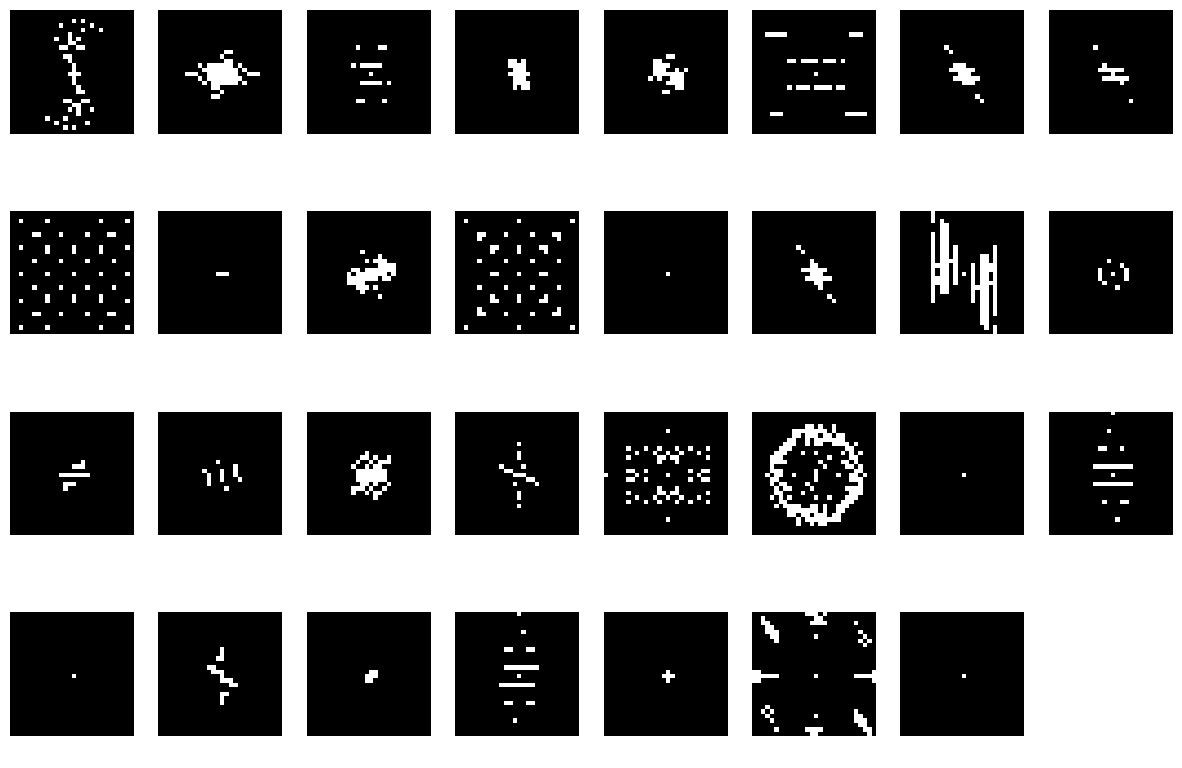

In [39]:
l = 0
fig, axes = plt.subplots(4, 8, figsize=(15, 10))
for img, ax in zip(textures, axes.ravel()):
    index1 = random.randint(0, 2 * 128)
    index2 = random.randint(0, 2 * 128)
    transform = np.fft.fft2(rgb2gray(img[index1 : 128 + index1, index2 : 128 + index2]))
    fshift = np.fft.fftshift(transform)
    bout_d_image = np.log(np.abs(fshift[50:-50, 50:-50]))
    # thresh1 = cv2.adaptiveThreshold(
    #     bout_d_image.astype("uint8"),
    #     np.max(bout_d_image),
    #     cv2.ADAPTIVE_THRESH_MEAN_C,
    #     cv2.THRESH_BINARY,
    #     51,
    #     0,
    # )

    binary_bout = bout_d_image > 5.5
    
    ax.imshow(bout_d_image>5.5, cmap="gray")

    ax.axis("off")
    
    if np.sum(binary_bout) <= 1:
        continue
    
    pos = (np.where(binary_bout))
    v = np.zeros((pos[0].shape[0], 2))
    v[:,0] = pos[0]
    v[:,1] = pos[1]

    cov = np.cov(v.T)

    eigval, eigvec = np.linalg.eig(cov)

axes[3, 7].axis("off")
plt.show()

In [6]:
imgs = {i: load_input_image(i,folder="train2") for i in range(12)}

In [ ]:
all_pieces = []
for im in imgs:
    seg = Segmentation(img)
    seg.find_pieces()
    all_pieces.append(seg.pieces)
all_pieces = np.array(all_pieces)
np.savetxt('all_pieces.txt', all_pieces)

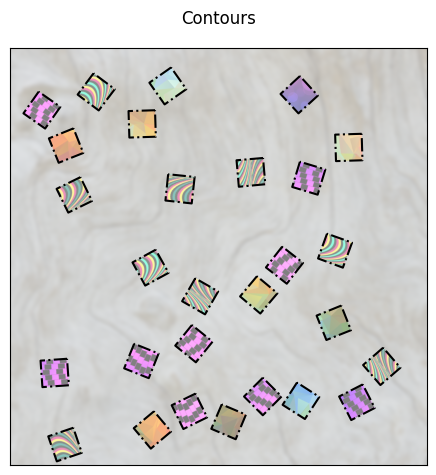

In [415]:
index_img = 5
img = imgs[index_img]
seg = Segmentation(img)
seg.find_pieces()
seg.plot_contours()

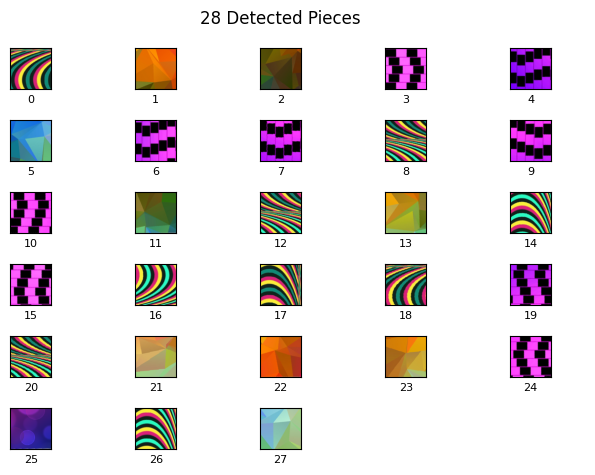

In [416]:
seg.plot_pieces()

In [476]:
means_border = img[:,-1,:].shape

(128, 3)

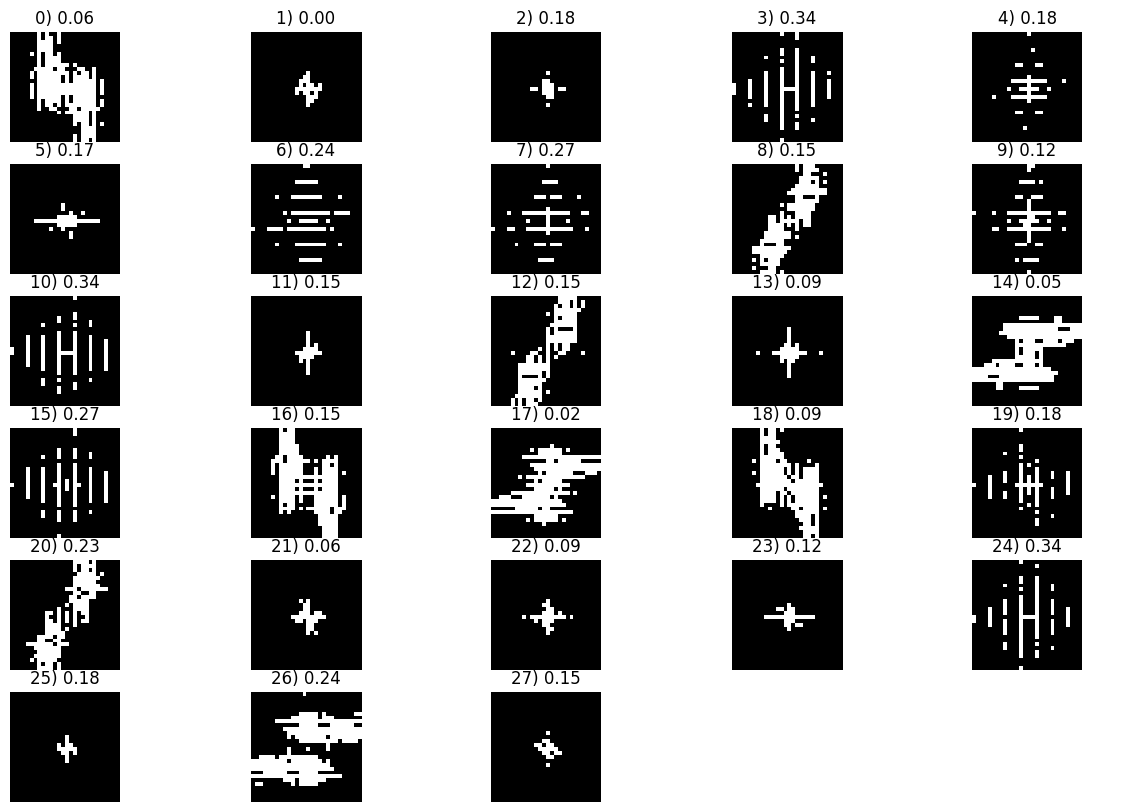

In [429]:
l = 0
fig, axes = plt.subplots(len(seg.pieces) // 5 + 1, 5, figsize=(15, 10))

reference = 1
threshold = 4.5
distances = get_distances(seg.pieces, threshold)

for i, (img, ax, d) in enumerate(zip(seg.pieces, axes.ravel(), distances)):
    transform = np.fft.fft2(rgb2gray(img))
    fshift = np.fft.fftshift(transform)
    bout_d_image = np.log(np.abs(fshift[50:-50, 50:-50]))

    binary_bout = bout_d_image > threshold
    
    ax.imshow(binary_bout, cmap="gray")

    ax.axis("off")

    ax.set_title(f'{i}) {distances[i][reference]:<.2f}')
    
for ax in axes.ravel()[len(seg.pieces):]:
    ax.axis("off")
plt.show()

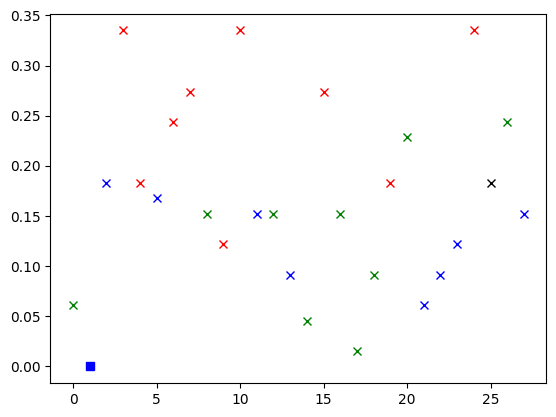

In [425]:
indexes = sorted_pieces[index_img]
colors = ["r", "g", "b", "k", "c", "m"]

dists_to_ref = np.array([distances[i][reference] for i in range(len(distances))])

for j, index in enumerate(indexes):

    if reference in index:
        plt.plot(reference, dists_to_ref[reference], c=colors[j], marker='s')

    plt.plot(index, dists_to_ref[index].T, c=colors[j], marker="x", linestyle='none')


In [435]:
features = np.array([get_features(seg.pieces[i]) for i in range(len(seg.pieces))])
features = np.hstack([features, get_distances(seg.pieces, 4.5)])
features = (features - np.mean(features, axis=0)) / np.maximum(1e-10, np.std(features, axis=0))
features.shape

(28, 86)

In [436]:
pca = KernelPCA(n_components=3,kernel="rbf")
features_PCA = pca.fit_transform(features)

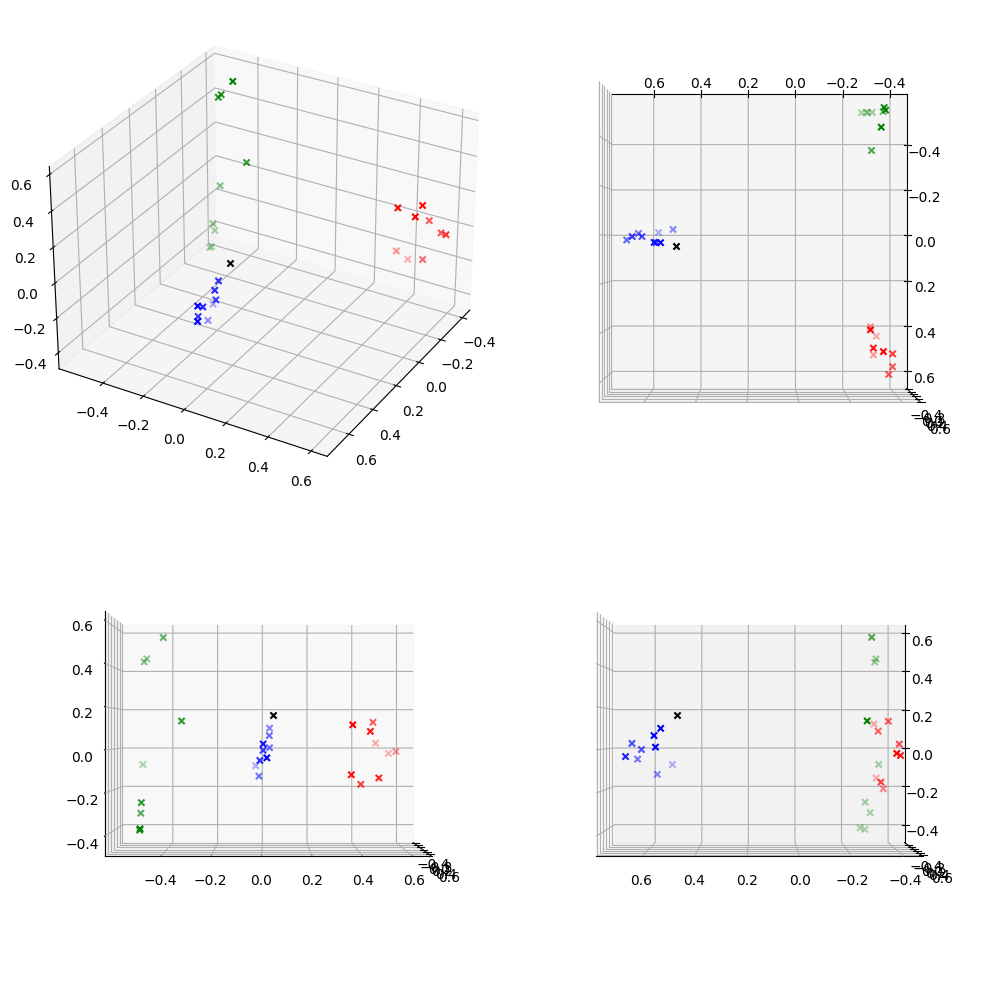

In [437]:
indexes = sorted_pieces[index_img]

colors = ["r", "g", "b", "k", "c", "m"]
orientation = [(30, 30), (90, 90), (0, 0), (0, 90)]

fig = plt.figure(figsize=(10, 10))
for i, o in enumerate(orientation):
    ax = fig.add_subplot(2, 2, i + 1, projection="3d")
    for j, index in enumerate(indexes):
        ax.scatter(*features_PCA[index].T, c=colors[j], marker="x")
        ax.view_init(elev=o[0], azim=o[1])

plt.tight_layout()
# plt.savefig(f'classification_{index_img}')
plt.show()

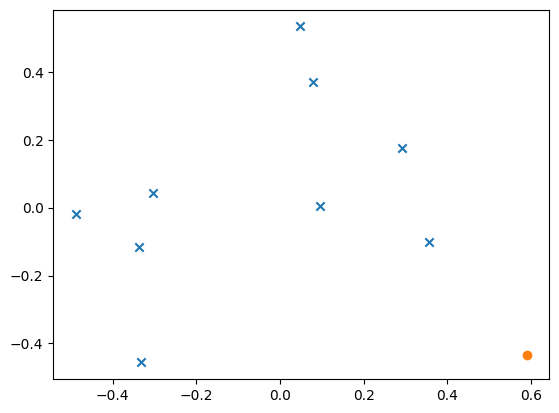

In [466]:
features_cluster_with_outlier = features[indexes[2]+indexes[3]]
pca = KernelPCA(n_components=2,kernel="rbf")
features_PCA = pca.fit_transform(features_cluster_with_outlier)
plt.scatter(*features_PCA[:-1].T, marker='x')
plt.scatter(*features_PCA[-1].T, marker='o')

In [134]:
from sklearn.mixture import GaussianMixture
gm =GaussianMixture(n_components=4)
labels = gm.fit_predict(features_PCA)
labels

array([1, 0, 1, 2, 0, 3, 1, 2, 2, 0, 2, 2, 2, 0, 2, 0, 2, 1, 0, 3, 3, 0,
       1, 1, 3, 0, 0, 2])

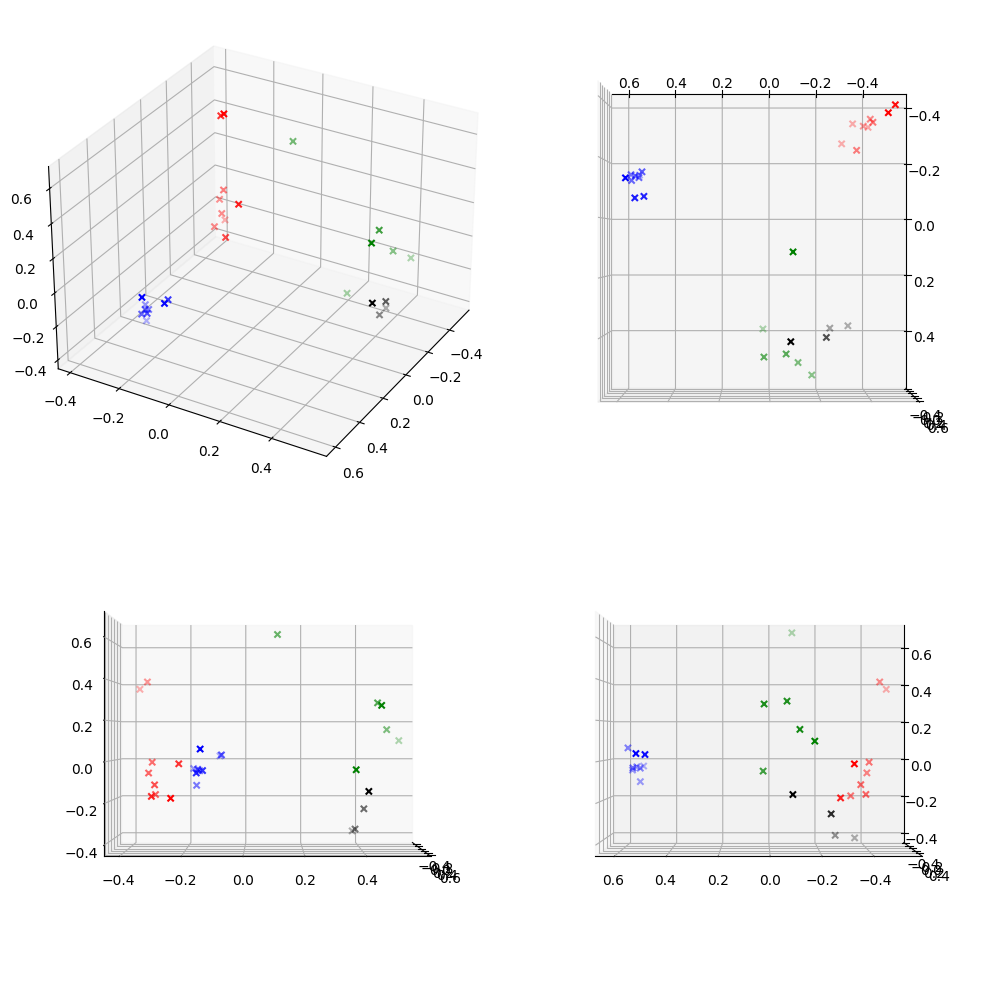

In [135]:
fig = plt.figure(figsize=(10,10))


for i, o in enumerate(orientation):
    ax = fig.add_subplot(2,2,i+1, projection='3d')
    for label in np.unique(labels):
        ax.scatter(*features_PCA[labels==label].T, c=colors[label], marker='x')
        ax.view_init(elev=o[0], azim=o[1])

plt.tight_layout()
plt.show()

In [140]:
from sklearn.cluster import OPTICS, DBSCAN
clustering = DBSCAN(eps=0.5, min_samples=9)
labels = clustering.fit_predict(features_PCA)
labels

array([-1,  0,  2,  1,  0,  2,  2,  1,  1,  0,  1,  1,  1,  0,  1,  0,  1,
        2,  0,  2,  2,  0,  2,  2,  2,  0,  0,  1])

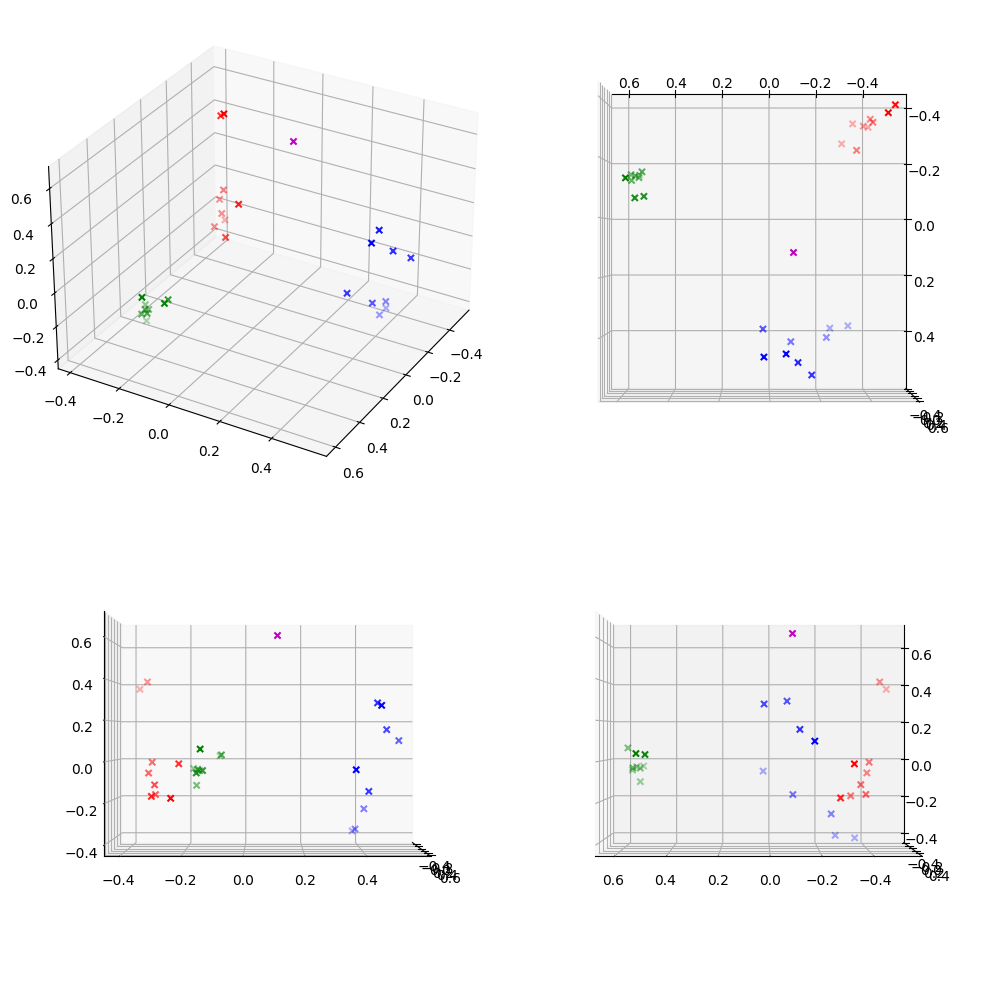

In [141]:
fig = plt.figure(figsize=(10,10))
for i, o in enumerate(orientation):
    ax = fig.add_subplot(2,2,i+1, projection='3d')
    for label in np.unique(labels):
        ax.scatter(*features_PCA[labels==label].T, c=colors[label], marker='x')
        ax.view_init(elev=o[0], azim=o[1])6
plt.tight_layout()
plt.show()

In [19]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, n_init=10)
labels = kmeans.fit_predict(features_PCA)
labels

array([2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 0, 1, 2, 0, 1, 1, 2, 0, 1],
      dtype=int32)

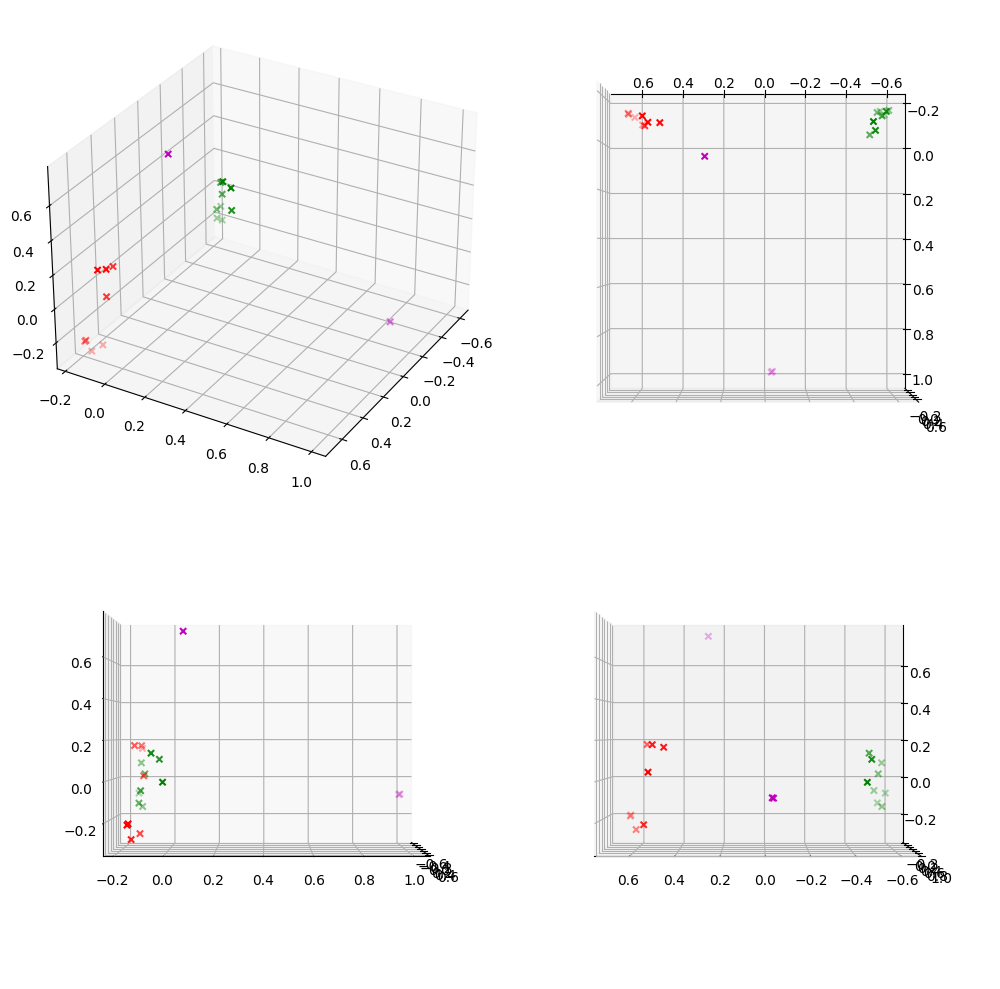

In [89]:
fig = plt.figure(figsize=(10,10))
for i, o in enumerate(orientation):
    ax = fig.add_subplot(2,2,i+1, projection='3d')
    for label in np.unique(labels):
        ax.scatter(*features_PCA[labels==label].T, c=colors[label], marker='x')
        ax.view_init(elev=o[0], azim=o[1])

plt.tight_layout()
plt.show()

In [21]:
#Piece 0
pieces_1 = [0,2,8,9,10,12,13,14,19]
pieces_2 = [1,5,6,11,16,21,22,25,26]
pieces_3 = [3,4,7,15,17,18,20,24,27]
outliers = [23]
indexes = [pieces_1,pieces_2,pieces_3,outliers]

In [22]:
#Piece 1 
pieces_1 = [2,7,4,8,10,11,12,12,14]
pieces_2 = [0,1,5,6,9,15,16,17,19]
pieces_3 = []
outliers = [3,18,20]
indexes = [pieces_1,pieces_2,pieces_3,outliers]

In [126]:
#Piece 2 
pieces_1 = [2,5,6,17,19,20,22,23,24]
pieces_2 = [1,4,9,13,15,18,21,25,26]
pieces_3 = [3,7,8,10,11,12,14,16,27]
outliers = [0]
indexes = [pieces_1,pieces_2,pieces_3,outliers]

In [30]:
#Piece 3
pieces_1 = [0,1,2,5,11,12,13,16,17]
pieces_2 = [3,4,6,7,8,9,15,18,20]
pieces_3 = []
outliers = [10,14,19]
indexes = [pieces_1,pieces_2,pieces_3,outliers]

In [125]:
#Piece 4
pieces_1 = [1,3,5,7,8,9,11,15,18]
pieces_2 = [2,4,6,10,12,13,14,17,19]
pieces_3 = []
outliers = [0,16]
indexes = [pieces_1,pieces_2,pieces_3,outliers]

In [96]:
#Piece 4
pieces_1 = [1,3,5,7,8,9,11,15,18]
pieces_2 = [2,4,6,10,12,13,14,17,19]
pieces_3 = []
outliers = [0,16]
indexes = [pieces_1,pieces_2,pieces_3,outliers]

In [10]:
#Piece 5
pieces_1 = [3,4,6,7,9,10,15,19,24]
pieces_2 = [0,8,12,14,16,17,18,20,26]
pieces_3 = [1,2,5,11,13,21,22,23,27]
outliers = [25]
indexes = [pieces_1,pieces_2,pieces_3,outliers]

In [27]:
#Piece 10
pieces_1 = [0,1,8,12,14,17,18,20,22]
pieces_2 = [2,3,4,9,10,15,16,21,23]
pieces_3 = [5,6,7,11,13,19,25,26,27]
outliers = []
indexes = [pieces_1,pieces_2,pieces_3,outliers]

In [20]:
#Piece 11
pieces_1 = [1,2,5,6,9,11,14,15,18]
pieces_2 = [3,4,7,8,10,12,13,16,17]
pieces_3 = []
outliers = [0]
indexes = [pieces_1,pieces_2,pieces_3,outliers]